IMPORT LIBRARIES

In [1]:
import warnings
warnings.filterwarnings('ignore')
import scipy
import pandas as pd
import math
import seaborn as sns
from tqdm import tqdm
import itertools
import cornac
from cornac.data import Reader
from cornac.eval_methods import RatioSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import pickle
import csv
import scipy.stats as stats
import scipy.special as special
import random
from openpyxl import Workbook 
import openpyxl 


Bad key "text.kerning_factor" on line 4 in
C:\anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


RUN NEUMF ON CAREERBUIDER12 DATASET

In [2]:
def ui_parser(tokens, **kwargs):
 
    if tokens[2]=='0' :  
        
        return [(tokens[0], tokens[1] , 2.0) ]
   
    return [(tokens[0], tokens[1] , 1.0) ]

In [5]:

fpath =r".........................\interactions.csv"

reader = Reader()
feedback = reader.read(fpath,parser=ui_parser,skip_lines=1, sep=',')


# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=feedback,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=123,
    rating_threshold=0.5,
)




# Instantiate the recommender models to be compared
ncf = cornac.models.NeuMF(
    num_factors=6,
    layers=[32, 16, 8, 4],
    act_fn="tanh",
    learner="adam",
    num_epochs=20,
    batch_size=256,
    lr=0.001,
    num_neg=40,
    seed=123,
)



# Instantiate evaluation metrics
ndcg_10 = cornac.metrics.NDCG(k=10)
rec_20= cornac.metrics.Recall(k=20)


models=[ncf]


# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=ratio_split,
    models=models,
    metrics=[ndcg_10, rec_20],
).run()

rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 40303
Number of items = 92673
Number of ratings = 290925
Max rating = 2.0
Min rating = 1.0
Global mean = 1.5
---
Test data:
Number of users = 23901
Number of items = 36811
Number of ratings = 63446
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 40303
Total items = 92673

[NeuMF] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Ranking:   0%|          | 0/23901 [00:00<?, ?it/s]


TEST:
...
      | NDCG@10 | Recall@20 |  Train (s) |  Test (s)
----- + ------- + --------- + ---------- + ---------
NeuMF |  0.0080 |    0.0188 | 11226.4506 | 1296.7831



In [6]:
data_test = ratio_split.test_set.uir_tuple

labels = data_test[2]

#make it binary
labels[labels<2] = 1
labels[labels>=2] = 0

NeuMF(UJ)
0.8412748701504758


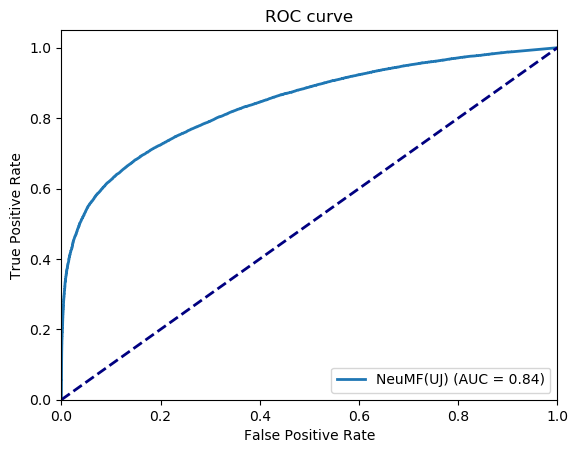

NeuMF(UJ)
0.8816294530265972


<Figure size 640x480 with 0 Axes>

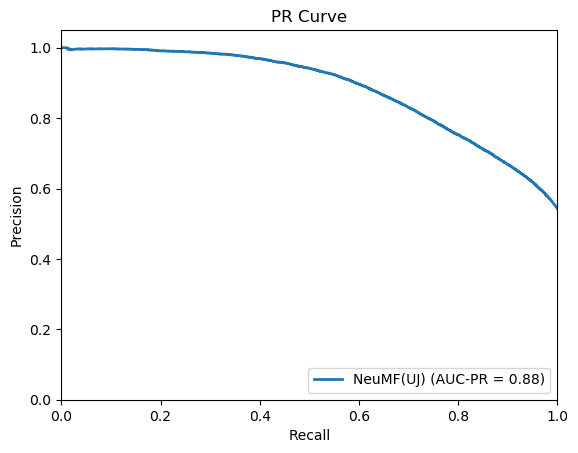

<Figure size 640x480 with 0 Axes>

In [7]:
#caluclate ROC and PR and plot

A = len(models)
scores_all = np.zeros((len(labels),A))    
for i in range(A):
    s = np.zeros(len(labels))
    #get users from data_test and predict score
    for j in range(data_test[0].shape[0]):
        user = data_test[0][j]
        item = data_test[1][j]
        s[j] = models[i].score(user, item) 
        
    s = s / max(s) #make it from 0-1
    scores_all[:,i]=s


np.save('scores.npy',scores_all)

plt.figure()
lw = 2
for i in range(A):    
    fpr, tpr, _ = roc_curve(labels, scores_all[:,i])
    roc_auc = auc(fpr, tpr)    
    
    if models[i].name=='NeuMF':
        models[i].name='NeuMF(UJ)'
        
    print(models[i].name)
    print(roc_auc)
        
    plt.plot(fpr, tpr, 
             lw=lw, label= models[i].name + ' (AUC = %0.2f)' % roc_auc)

    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title= 'ROC curve'
plt.title(title)
plt.legend(loc="lower right")
plt.show()
plt.savefig(title + '.png')
    

plt.figure()
lw = 2
for i in range(A):    
    pr, rec, thr = precision_recall_curve(labels, scores_all[:,i] )
    avg_pr = average_precision_score(labels, scores_all[:,i])
    
    print(models[i].name)
    print(avg_pr)
    
    
    plt.plot(rec, pr, 
             lw=lw, label=models[i].name + ' (AUC-PR = %0.2f)' % avg_pr)
    
title = 'PR curve'
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig(title + '.png')

DEFINE AUXILIARY FUNCTIONS

In [8]:
def KLD(D1,D2):
    a = np.asarray(D1, dtype=np.float)
    b = np.asarray(D2, dtype=np.float)

    return np.sum(np.where(a != 0 , a * np.log((a +0.00001)/(b+0.00001)), 0))

def NDKL(df,p):
    Z = np.sum(1/(np.log2(np.arange(1,11)+1)))
    total=0

    for i in range(1,11): 
        value=df[:i].value_counts(normalize = True)
        value=value.to_dict()
        D1=[]
        for j in range(len(p)):
            if j in value.keys():
                D1.append(value[j])
            else:
                D1.append(0)
        total=total+(1/math.log2(i+1)) * KLD(D1,p)

    return (1/Z)*total

In [9]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0

def ndcg_at_k(df, k, method=0):
    r=list(df)
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [10]:

def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.

    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:

            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """
    
    a=list(a.values())
    a=np.array(a)
    #print(a)
    b=list(b.values())
    b=np.array(b)
    #print(b)

    if k is None:
        k = len(a)
    if len(a) != len(b):
        raise NameError('The two arrays need to have same lengths')
    k = min(k,len(a))
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall

In [11]:
def infeasibleIndexBelowMin(df,p):
    
    """ Params: df = dataFrame for Ranked List, a= No of Values of Protected Attribute
                desired_p = desired proportion of ai's (Array){Provisioned for Later Modification}
                k initial value need to set(default=10)
    
    """
    
    data = df[:10]
    a=len(p)
    desired_p = p
    tao_r = 10
    infeasibleFlag = False
    InfIndex_tao_r = 0
    InfCount_tao_r = 0
    
    
    for k in range(1,tao_r):
        data_temp_k = data[:k]
        infeasibleFlag = False
        for i in range(a):
            desired_p_ai = desired_p[i]
            observed_count_ai = len(data_temp_k[data_temp_k==i])
            desired_count_ai= math.floor(desired_p_ai*k)
            if observed_count_ai < desired_count_ai:
                infeasibleFlag = True
                ## Increment Infeasible Count
                InfCount_tao_r += 1
                
        ## Increment Infeasible Index
        if infeasibleFlag == True:
            InfIndex_tao_r += 1
    if InfIndex_tao_r > 99:
        print(f'Error at {a} and it is: {InfIndex_tao_r}')
    Infeasible_Return_array = [InfIndex_tao_r, InfCount_tao_r]
    return InfIndex_tao_r
    

In [12]:
def infeasibleIndexBelowMax(df,p):
    
    """ Params: df = dataFrame for Ranked List, a= No of Values of Protected Attribute
                desired_p = desired proportion of ai's (Array){Provisioned for Later Modification}
                k initial value need to set(default=10)
    
    """
    
    data = df[:10]
    a=len(p)
    desired_p = p
    tao_r = 10
    infeasibleFlag = False
    InfIndex_tao_r = 0
    InfCount_tao_r = 0
    
    
    for k in range(1,tao_r):
        data_temp_k = data[:k]
        infeasibleFlag = False
        for i in range(a):
            desired_p_ai = desired_p[i]
            observed_count_ai = len(data_temp_k[data_temp_k==i])
            desired_count_ai= math.ceil(desired_p_ai*k)
            if observed_count_ai > desired_count_ai:
                infeasibleFlag = True
                ## Increment Infeasible Count
                InfCount_tao_r += 1
                
        ## Increment Infeasible Index
        if infeasibleFlag == True:
            InfIndex_tao_r += 1
    if InfIndex_tao_r > 99:
        print(f'Error at {a} and it is: {InfIndex_tao_r}')
    Infeasible_Return_array = [InfIndex_tao_r, InfCount_tao_r]
    return InfIndex_tao_r

READ JOBS INFO

In [13]:
item_info = pd.read_table(r"\items_users.csv", sep='\t',skiprows=1,
                        engine='python', names=['item_id','city','state','country','zip5','ReqTopic','DescTopic'
                                                ,'TitTopic'])


item_info=item_info.drop("zip5", axis=1)
item_info.head()

,item_id,city,state,country,ReqTopic,DescTopic,TitTopic
0,3,Fairfax,VA,US,2,9,0
1,198,Orlando,FL,US,13,9,18
2,215,Winter Garden,FL,US,13,7,0
3,219,Orlando,FL,US,13,9,5
4,221,Altamonte Springs,FL,US,13,9,18


In [14]:
jobs=item_info.to_numpy()
print(jobs[0])

[3 'Fairfax' 'VA' 'US' 2 9 0]


READ USERS INFO

In [15]:
user_info = pd.read_table(r"C:\Users\sdav\Desktop\Aegean\Διπλωματική\cb12 dataset\users_prop.csv", sep='\t',skiprows=1,
                        engine='python', names=['user_id','city','state','country'
                                                ,'zip5','DegreeType',
                                                'TotalYearsExperience','MajTopic'])

user_info.head()

,user_id,city,state,country,zip5,DegreeType,TotalYearsExperience,MajTopic
0,47,Paramount,CA,US,90723,High School,10.0,0
1,72,La Mesa,CA,US,91941,Master's,8.0,0
2,80,Williamstown,NJ,US,08094,High School,11.0,4
3,98,Astoria,NY,US,11105,Master's,3.0,0
4,123,Baton Rouge,LA,US,70808,Bachelor's,9.0,2


In [16]:
users=user_info.to_numpy()
print(users[0])

[47 'Paramount' 'CA' 'US' '90723' 'High School' 10.0 0]


MATCH RATINGS WITH USERS AND JOBS INFO

In [18]:
score_neumf=scores_all[:]



test_data = ratio_split.test_set.uir_tuple
iid = ratio_split.global_iid_map
uid = ratio_split.global_uid_map

 
user_list=[]
unique_users=[]
neumf_ratings=[]

        
for k in range (test_data[1].shape[0]):
    user_state,user_country,job_state,job_country=[],[],[],[]
    #print(test_data[1].shape[0]-k)
    for n in range (len(jobs)):
        if (str(jobs[n][0]) in iid):
            if (iid[str(jobs[n][0])] == test_data[1][k]) :
                job_state=jobs[n][4]
                job_country=jobs[n][2]
                break
    
    for n in range (len(users)):
        if (str(users[n][0]) in uid) and (uid[str(users[n][0])] == test_data[0][k]) :
            user_state=users[n][7]
            user_country=users[n][2]
            break
    
    
    job = test_data[1][k] 
    user = test_data[0][k]
    
    rate_neumf = score_neumf[k]
    
    
    
    user_list.append(user)
    
    neumf_ratings.append((job,user,rate_neumf,user_state,user_country,job_state,job_country))
     

    
        
for user in user_list:
    if user not in unique_users:
        unique_users.append(user)


AUXILIARY FUNCTIONS TO CREATE DATA FOR RERANKING ALGOS (MAJTOPIC AND STATE MATCHED ATTRIBUTES)

In [19]:
def experiment (user_index,k_max,ratings):
    scores={}
    for i in range(4):
        scoresgen=[]
        ind0,ind1=0,0
        if i==0:
            ind0=0
            ind1=0
        elif i==1:
            ind0=0
            ind1=1
        elif i==2: 
            ind0=1
            ind1=0
        elif i==3:
            ind0=1
            ind1=1
        
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 3 :
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    score=[ratings[m][2], 1 ,1]
                    scoresgen.append(score)
           
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 2 and  ratings[m][6] != ratings[m][4]:
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2],1,0]
                    scoresgen.append(score)
      
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,ind1]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [20]:
def experiment1 (user_index,k_max,ratings):
    scores={}
    for j in range(4):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            ind1=0
            i=0
        elif j==1:
            ind0=0
            ind1=1
            i=1
        elif j==2: 
            ind0=1
            ind1=0
            i=2
        elif j==3:
            ind0=1
            ind1=1
            i=3
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 3 :
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
            
                    score=[ratings[m][2], 1,1,i]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 2 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
        
                    score=[ratings[m][2], 1,0,i]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                
                    score=[ratings[m][2], 0,1,i]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,ind1,i]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [21]:
def experiment2 (user_index,k_max,ratings):
    scores={}
    for j in range(4):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            ind1=0
            i=0
        elif j==1:
            ind0=0
            ind1=1
            i=1
        elif j==2: 
            ind0=1
            ind1=0
            i=2
        elif j==3:
            ind0=1
            ind1=1
            i=3
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 3 :
                
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                
                    score=[ratings[m][2], 1,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 2 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                
                    score=[ratings[m][2], 1,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    
                    score=[ratings[m][2], 0,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                
                    score=[ratings[m][2], 0,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,ind1,i, ratings[m][3],ratings[m][4],0]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

AUXILIARY FUNCTION TO CREATE DATA FOR RERANKING ALGOS (MAJTOPIC MATCHED ATTRIBUTE)

In [22]:
def experiment11 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            i=0
        elif j==1:
            ind0=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 1 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                  
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,0,i]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [23]:
def experiment111 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind0=0
            i=0
        elif j==1:
            ind0=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 1 and  ratings[m][6] != ratings[m][4]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 1 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                  
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,ind0,0,i,ratings[m][3],ratings[m][4],0]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

AUXILIARY FUNCTION TO CREATE DATA FOR RERANKING ALGOS (STATE MATCHE ATTRIBUTE)

In [24]:
def experiment12 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind1=0
            i=0
        elif j==1:
            ind1=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 0 and  ratings[m][6] != ratings[m][4]:
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 0 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,0,ind1,i]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

In [25]:
def experiment121 (user_index,k_max,ratings):
    scores={}
    for j in range(2):
        scoresgen=[]
        ind0,ind1=0,0
        if j==0:
            ind1=0
            i=0
        elif j==1:
            ind1=1
            i=1
        for m in range(len(ratings)):
            if ratings[m][1]==user_index:
                if ratings[m][5] == ratings[m][3] and  ratings[m][6] == ratings[m][4] and i == 1 :
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
            
                if ratings[m][1]==user_index  and ratings[m][5]== ratings[m][3] and i == 0 and  ratings[m][6] != ratings[m][4]:
                   
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 1,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
       
                if ratings[m][1]==user_index  and ratings[m][6]== ratings[m][4] and i == 0 and ratings[m][5] != ratings[m][3]:
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,1,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        
                if ratings[m][1]==user_index  and i==0 and ratings[m][5] != ratings[m][3] and  ratings[m][6] != ratings[m][4] : 
                    
                    if ratings[m][2] < 0 :
                        l = list(ratings[m])
                        l[2] = 0.0 
                        ratings[m]=tuple(l)
                    #print(ratings[m][2])
                    score=[ratings[m][2], 0,0,i,ratings[m][3],ratings[m][4],ratings[m][0]]
                    scoresgen.append(score)
        while len(scoresgen) < k_max :
            scoresgen.append([0.0,0,ind1,i,ratings[m][3],ratings[m][4],0]) 
        scoresgen.sort(reverse=True)         
       
        for j in range(k_max):
            scores[(i,j)]=scoresgen[j]
    #print(scores)
    #print("-------------------")
    return scores

DETGREEDY ALGORITHM

In [26]:
def DetGreedy(data,p,k_max):
    rankedAttList = [] 
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        #print("belowMinSet:",belowMin)
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        #print("belowMaxSet:",belowMax)
        s={}
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])

In [27]:
def DetGreedy1(data,p,k_max):
    rankedAttList = [] 
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        #print("belowMinSet:",belowMin)
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        #print("belowMaxSet:",belowMax)
        s={}
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])

GREEDY ALGORITHM 

In [28]:
def Greedy(data,k_max):
    df = pd.Series(data).rename_axis(['ai', 'index']).reset_index(name='score')
    df.sort_values(by=['score'], inplace=True,ascending=False)
    df = df.reset_index(drop=True)
        
        
    return df[:k_max]

CAL ALGORITHM

In [31]:
# η συνάρτηση παίρνει ως εισόδους την βάση δεδομένων data 
# την πιθανότητα εμφάνισης όλων των attributes σαν ένα attribute π.χ εδ΄ω΄ [1/6,1/6,1/6,1/6,1/6,1/6]
# τα top k_max αποτελέσματα που θέλουμε να προτείνουμε π.χ εδώ top-4
# τους πίνακες συχνοτήτων εμφάνισης κα΄θε  attibute values σε κάθε attibute 

def CAL(data,p,k_max):
    
    # βοηθητικές μεταβλητές
    rankedAttList,rankedScoreList,rankedAttListA,rankedAttListB = [],[],[],[]
    belowMinAtt,belowMaxAtt={},{}
    rankedAttLists=[]
    counts={}
    countsAtt=[]
    xNdkl={}
    att={}
    Algos=[]
    indexes, attindex=[],[]
    sxima=1 
    
    # αρχικοποίηση βοηθητικών δομών δεδομένων
    for i in range(len(p)): 
        Algos.append([])
        sxima*=len(p[i])
        rankedAttLists.append([])
        countsc={}
        for j in range(len(p[i])):
            countsc[j]=0
        countsAtt.append(countsc)
    for k in range(0,k_max+1):
        xNdkl[k]=1000 
    for i in range(sxima):
        counts[i]=0 
    countsAtt.append(counts)
    #print(countsAtt)
    
    # αρχικοποίηση και υπολογισμός του πίνακα των indexes π.χ 1---> 0,1 male 35 years old
    for i in range(sxima):
        indexes.append([])
    for i in range(sxima):
        for j in range(1,len(p)+1):
            indexes[i].append(data[(i,0)][j])
    #print(indexes)
    
    for k in range(1,k_max+1): # για το top-k 
        i=0
        flag=0
        
        for pk in p: # για κάθε attribute  υπολόγισε το belowMax και belowMin
            belowMinAtt[i] = {ai for ai,v in countsAtt[i].items() if v < math.floor(k*pk[ai])}
            #print("belowMinSet:",belowMinAtt)
            belowMaxAtt[i] = {ai for ai,v in countsAtt[i].items() if v >= math.floor(k*pk[ai]) and v <math.ceil(k*pk[ai])}
            #print("belowMaxSet:",belowMaxAtt)
            i+=1

        
        belowMax=[]
        belowMin=[]
        s={}
        for key in belowMinAtt:
            if len(belowMinAtt[key])!=0:
                flag=1
                break
    
              
        if flag==1:   # αν υπάρχει ένα  belowMin από κα΄ποιο  attribute γεμάτο
            for key in belowMinAtt:
                if len(belowMinAtt[key])!=0:
                    belowMaxAtt[key]= belowMinAtt[key] 
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMin.append(j)  # υπολόγισε το συνολικά belowMin 
            for i in belowMin:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get) # και πάρε αυτό με το μέγιστο score
        else: # αλλιώς
            for x in range (len(p)):
                m={}
                for pos in range(k+1,k_max):
                    m[pos]  = [ai for ai,v in countsAtt[x].items() if v < math.floor(pos*p[x][ai])] 
                #print(m) 
                
                for pos in m:
                    if len(m[pos])!=0:
                        belowMaxAtt[x] = list( set(belowMaxAtt[x]).intersection(set(m[pos])) )
                        break     
                    
            #print("here",belowMaxAtt)
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMax.append(j)   # υπολόγισε το συνολικά belowMax   
            for i in belowMax:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get)  # και πάρε αυτό με το μέγιστο score
        
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,countsAtt[len(p)][nextAtt])][0])
        countsAtt[len(p)][nextAtt]+=1
     
        
        for i in range(len(p)):
            att[i] = indexes[nextAtt][i]
            
     
        xNDKL=0
        for i in range(len(p)):  
            countsAtt[i][att[i]]+=1
            rankedAttLists[i].append(att[i]) 
            Algos[i]=pd.DataFrame(list(zip(rankedAttLists[i], rankedScoreList)),columns =['ai', 'score'])   
            xNDKL+= NDKL(Algos[i]['ai'],p[i])
            
        xNdkl[k]= xNDKL # υπολογισμός του xNDKL 

        
   
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score']), xNdkl[k]

In [32]:
# η συνάρτηση παίρνει ως εισόδους την βάση δεδομένων data 
# την πιθανότητα εμφάνισης όλων των attributes σαν ένα attribute π.χ εδ΄ω΄ [1/6,1/6,1/6,1/6,1/6,1/6]
# τα top k_max αποτελέσματα που θέλουμε να προτείνουμε π.χ εδώ top-4
# τους πίνακες συχνοτήτων εμφάνισης κα΄θε  attibute values σε κάθε attibute 

def CAL2(data,p,k_max):
    
    # βοηθητικές μεταβλητές
    rankedAttList,rankedScoreList,rankedAttListA,rankedAttListB = [],[],[],[]
    belowMinAtt,belowMaxAtt={},{}
    rankedAttLists=[]
    counts={}
    countsAtt=[]
    xNdkl={}
    att={}
    Algos=[]
    indexes, attindex=[],[]
    sxima=1 
    
    # αρχικοποίηση βοηθητικών δομών δεδομένων
    for i in range(len(p)): 
        Algos.append([])
        sxima*=len(p[i])
        rankedAttLists.append([])
        countsc={}
        for j in range(len(p[i])):
            countsc[j]=0
        countsAtt.append(countsc)
    for k in range(0,k_max+1):
        xNdkl[k]=1000 
    for i in range(sxima):
        counts[i]=0 
    countsAtt.append(counts)
    #print(countsAtt)
    
    # αρχικοποίηση και υπολογισμός του πίνακα των indexes π.χ 1---> 0,1 male 35 years old
    for i in range(sxima):
        indexes.append([])
    for i in range(sxima):
        for j in range(1,len(p)+1):
            indexes[i].append(data[(i,0)][j])
    #print(indexes)
    
    for k in range(1,k_max+1): # για το top-k 
        i=0
        flag=0
        
        for pk in p: # για κάθε attribute  υπολόγισε το belowMax και belowMin
            belowMinAtt[i] = {ai for ai,v in countsAtt[i].items() if v < math.floor(k*pk[ai])}
            #print("belowMinSet:",belowMinAtt)
            belowMaxAtt[i] = {ai for ai,v in countsAtt[i].items() if v >= math.floor(k*pk[ai]) and v <math.ceil(k*pk[ai])}
            #print("belowMaxSet:",belowMaxAtt)
            i+=1

        
        belowMax=[]
        belowMin=[]
        s={}
        for key in belowMinAtt:
            if len(belowMinAtt[key])!=0:
                flag=1
                break
    
              
        if flag==1:   # αν υπάρχει ένα  belowMin από κα΄ποιο  attribute γεμάτο
            for key in belowMinAtt:
                if len(belowMinAtt[key])!=0:
                    belowMaxAtt[key]= belowMinAtt[key] 
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMin.append(j)  # υπολόγισε το συνολικά belowMin 
            for i in belowMin:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get) # και πάρε αυτό με το μέγιστο score
        else: # αλλιώς
            for x in range (len(p)):
                m={}
                for pos in range(k+1,k_max):
                    m[pos]  = [ai for ai,v in countsAtt[x].items() if v < math.floor(pos*p[x][ai])] 
                #print(m) 
                
                for pos in m:
                    if len(m[pos])!=0:
                        belowMaxAtt[x] = list( set(belowMaxAtt[x]).intersection(set(m[pos])) )
                        break     
                    
            #print("here",belowMaxAtt)
            for t in itertools.product(*belowMaxAtt.values()):
                for j in range(len(indexes)):
                    res = (indexes[j]==np.asarray(t)).all()
                    if res==True:
                        belowMax.append(j)   # υπολόγισε το συνολικά belowMax   
            for i in belowMax:
                s[i]=data[(i,countsAtt[len(p)][i])]
            nextAtt = max(s,key=s.get)  # και πάρε αυτό με το μέγιστο score
        
       
        
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,countsAtt[len(p)][nextAtt])])
        countsAtt[len(p)][nextAtt]+=1
     
        
        for i in range(len(p)):
            att[i] = indexes[nextAtt][i]
            
     
        xNDKL=0
        for i in range(len(p)):  
            countsAtt[i][att[i]]+=1
            rankedAttLists[i].append(att[i]) 
            Algos[i]=pd.DataFrame(list(zip(rankedAttLists[i], rankedScoreList)),columns =['ai', 'score'])   
            xNDKL+= NDKL(Algos[i]['ai'],p[i])
    
            
        xNdkl[k]= xNDKL # υπολογισμός του xNDKL 
    
        
    alg=pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score']) 
    
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score']), xNdkl[k], NDKL(Algos[0]['ai'],p[0]),NDKL(Algos[1]['ai'],p[1]),NDKL(alg['ai'],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMin(Algos[0]['ai'],p[0]),infeasibleIndexBelowMin(Algos[1]['ai'],p[1]),infeasibleIndexBelowMin(alg['ai'],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMax(Algos[0]['ai'],p[0]),infeasibleIndexBelowMax(Algos[1]['ai'],p[1]),infeasibleIndexBelowMax(alg['ai'],[1/16,3/16,3/16,9/16])

AUXILIARY FUNCTION TO CALCULATE  metrics FROM OUTPUTS OF RERANKING ALGOS

In [33]:
def xxxNDKL(algo,pA,pB):


    k_max=10 # top-4 αποτελεσμαάτων

    
    table=algo


    dataA={}
    dataB={}
    dataAB={}
    AlgoA={}
    AlgoB={} 
    AlgoAB={}
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    rankedAttListAB=[]
    rankedScoreListAB=[]
    A,B, AB =[],[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
    
    for i in range (4):  # αρχικοποίηση πινάκα και set για το attribute group ages
        AB.append(0)
        for j in range (k_max):
            dataAB[(i,j)]=0.0
    

    for k in range (0,4):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων 
        for i in range(0,k_max):
            for j in range(len(pA)):
                if table[(k,i)][1]==j:
                    dataA[(j,A[j])]=table[(k,i)][0]
                    rankedAttListA.append(j)
                    rankedScoreListA.append(table[(k,i)][0])
                    A[j]+=1
    rankedScoreListA.sort(reverse=True) 
    rankedAttListA=[x for _,x in sorted(zip(rankedScoreListA,rankedAttListA), reverse=True)]
        
    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for k in range(0,4):
        for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
            for j in range (len(pB)):
                if table[(k,i)][2]==j:
                    dataB[(j,B[j])]=table[(k,i)][0]
                    rankedAttListB.append(j)
                    rankedScoreListB.append(table[(k,i)][0])
                    B[j]+=1    
    rankedScoreListB.sort(reverse=True) 
    rankedAttListB=[x for _,x in sorted(zip(rankedScoreListB,rankedAttListB), reverse=True)] 
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
    
    
    for k in range(0,4):
        for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
            for j in range (4):
                if table[(k,i)][3]==j:
                    dataAB[(j,AB[j])]=table[(k,i)][0]
                    rankedAttListAB.append(j)
                    rankedScoreListAB.append(table[(k,i)][0])
                    AB[j]+=1    
    rankedScoreListAB.sort(reverse=True) 
    rankedAttListAB=[x for _,x in sorted(zip(rankedScoreListAB,rankedAttListAB), reverse=True)] 
        
    AlgoAB=pd.DataFrame(list(zip(rankedAttListAB, rankedScoreListAB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   

   
    
    xNDKLold = NDKL(AlgoA['ai'][:10],pA)+NDKL(AlgoB['ai'][:10],pB) 
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    return xNDKLold , NDKL(AlgoA['ai'][:10],pA), NDKL(AlgoB['ai'][:10],pB), NDKL(AlgoAB['ai'][:10],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMin(AlgoA['ai'],pA),infeasibleIndexBelowMin(AlgoB['ai'],pB),infeasibleIndexBelowMin(AlgoAB['ai'],[1/16,3/16,3/16,9/16]),infeasibleIndexBelowMax(AlgoA['ai'],pA),infeasibleIndexBelowMax(AlgoB['ai'],pB),infeasibleIndexBelowMax(AlgoAB['ai'],[1/16,3/16,3/16,9/16])


EXPERIMENT WITH NEUMF VS DETGREEDY   BOTH ATTRITUBES AS ONE (MAJTOPIC+STATE)

In [34]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0
k_max=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB, _,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)


ndcg(detgreedy_ba) [0.96228517]
xNDKL(detgreedy) 0.5452247564378367
NDKL(detgreedy-discipline) 0.330061212610594
NDKL(detgreedy-region) 0.21516354382717173
NDKL(detgreedy-region-discipline) 0.6549727639487817
-------------------------------------------------
xNDKL(neumf) 1.1359468569424753
NDKL(neumf-discipline) 0.5679734284712377
NDKL(neumf-region) 0.5679734284712377
NDKL(neumf-region-discipline) 1.4785684218594628


EXPERIMENT WITH NEUMF VS DETGREEDY   SOLO ATTRIBUTE (MAJTOPIC)

In [35]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0
k_max=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB, _,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment11(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/4,3/4],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/4,3/4],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

ndcg(detgreedy_ba) [0.99314839]
xNDKL(detgreedy) 1.2447033407250359
NDKL(detgreedy-discipline) 0.469878926021614
NDKL(detgreedy-region) 0.774824414703378
NDKL(detgreedy-region-discipline) 1.5854320167537588
-------------------------------------------------
xNDKL(neumf) 1.1359468569424753
NDKL(neumf-discipline) 0.5679734284712377
NDKL(neumf-region) 0.5679734284712377
NDKL(neumf-region-discipline) 1.4785684218594628


EXPERIMENT WITH NEUMF VS DETGREEDY  SOLO ATTRIBUTE  (STATE)

In [36]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0
k_max=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB, _ ,_,_,_,_,_=xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment12(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/4,3/4],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/4,3/4],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

ndcg(detgreedy_ba) [0.95172555]
xNDKL(detgreedy) 1.5396772712981797
NDKL(detgreedy-discipline) 1.2698690643038157
NDKL(detgreedy-region) 0.2698082069944224
NDKL(detgreedy-region-discipline) 1.7054183652759352
-------------------------------------------------
xNDKL(neumf) 1.1359468569424753
NDKL(neumf-discipline) 0.5679734284712377
NDKL(neumf-region) 0.5679734284712377
NDKL(neumf-region-discipline) 1.4785684218594628


EXPERIMENTS ON CLUSTER OF USERS

In [37]:
cluster=[]
for i in range (100):
    cluster.append(random.randint(0, len(unique_users)))
print (cluster)

[1837, 3958, 4770, 2829, 4110, 21495, 18635, 5521, 9831, 18746, 19149, 11741, 11429, 5650, 14834, 22613, 13865, 23557, 100, 8593, 53, 8071, 13118, 16876, 11885, 21700, 4045, 9257, 5319, 14480, 23678, 10076, 13906, 23057, 6190, 12578, 2935, 8870, 9150, 21191, 16582, 1855, 2761, 20625, 17984, 3710, 11293, 4400, 23148, 11131, 15628, 22364, 18045, 15177, 11883, 11539, 15384, 3373, 11593, 2994, 11693, 7814, 13279, 12624, 1334, 4507, 4259, 1784, 8063, 3264, 18660, 5162, 4572, 11845, 5435, 1936, 19137, 15022, 21330, 12563, 14468, 19307, 13244, 20899, 18997, 3622, 16734, 17104, 18716, 2788, 6457, 2351, 12787, 3919, 11341, 21083, 11016, 6412, 2172, 22639]


EXPERIMENTS CAL ALGORITHM

In [39]:
workbook = Workbook() 

workbook.save(filename="careerBuilder1.xlsx") 


wb = openpyxl.load_workbook("careerBuilder1.xlsx") 

sheet = wb.active 

ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
oldNDKL=[]
ndkl_dis= []
ndkl_reg= []
ndkl_d_reg = []
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_ndkl=0
aver_ndcg_S=0
aver_ndcg_reg=0
aver_ndkl_d_r=0
aver_ndcg_dis=0

aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []
kendalltxGF=[]
distanceNew=[]
k_max=10



for i in range(len(cluster)):
    #print(len(unique_users)-cluster[i])
    #print(unique_users[i])
    data=experiment(unique_users[cluster[i]],10,neumf_ratings)
    kendalldata=experiment2(unique_users[cluster[i]],10,neumf_ratings)
    #print(data)
   
    
    algo, xNdkl,ndkl_discipline, ndkl_region, ndkl_d_r , index_min_dis, index_min_reg, index_min_d_r, index_max_dis, index_max_reg, index_max_d_r =CAL2(data,p,10)
    

    
    algo1, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
    #print(algo1)
    for v in range (10):
        if algo1["score"][v][6]!=0:
            x1= algo1["score"][v][4]
            y1= algo1["score"][v][5]
            
    for c in range (10):         
        if algo1['score'][c][6]!=0:
            x1s= algo1['score'][c][4]
            y1s= algo1['score'][c][5]
            break 
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo1["score"][c][3]
    
    for j in range(len(cluster)) :
        if j>i:
            kendalldataz=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][3]
            
            kendalltxGF.append(kendall_top_k(w,z,10))
    

            for c in range (10):
                if algoSkendall['score'][c][6]!=0:
                    x2s= algoSkendall['score'][c][4]
                    y2s= algoSkendall['score'][c][5]
                    break 
            
            a = np.array((int(x1s), ord(y1s[0])+ord(y1s[1])))
            q = np.array((int(x2s), ord(y2s[0])+ord(y2s[1])))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
            
            distanceNew.append(distance+0.00001)    
    
     
    
    xNDKL.append(xNdkl)
    ndkl_dis.append(ndkl_discipline)
    ndkl_reg.append(ndkl_region)
    ndkl_d_reg.append(ndkl_d_r)
    
    min_dis.append(index_min_dis)
    #print("min_dis",min_dis)
    min_reg.append(index_min_reg)
    min_d_reg.append(index_min_d_r)
    max_dis.append(index_max_dis)
    max_reg.append(index_max_reg)
    max_d_reg.append(index_max_d_r)
    
    algoS, xNdkl=CAL(data,p,10)
    #print(algo)

    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        

aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(CAL)",aver_ndcg_S)        

aver_ndkl= sum(xNDKL)/len(xNDKL)
print("NDKL-CAL",aver_ndkl)

aver_ndkl_dis= sum(ndkl_dis)/len(ndkl_dis)
print("NDKL-CAL-dis",aver_ndkl_dis)

aver_ndkl_reg= sum(ndkl_reg)/len(ndkl_reg)
print("NDKL-CAL-region",aver_ndkl_reg)

aver_ndkl_d_r= sum(ndkl_d_reg)/len(ndkl_d_reg)
print("NDKL-CAL-d+r",aver_ndkl_d_r)




aver_min_dis= sum(min_dis)/len(min_dis)
print("min-CAL-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-CAL-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-CAL-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-CAL-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-CAL-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-CAL-d+r",aver_max_d_r)

sheet.append(distanceNew)
sheet.append(kendalltxGF)
#sheet.append(e)

wb.save('careerBuilder1.xlsx')

#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltxGF)
e=[]
e=np.divide(kendalltxGF,distanceNew)
print('e',e)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)


ndcg(CAL) [0.63448901]
NDKL-CAL 0.23601101676622696
NDKL-CAL-dis 0.11228266056577484
NDKL-CAL-region 0.12372835620045208
NDKL-CAL-d+r 0.42325625793265914
min-CAL-dis 0.0
min-CAL-region 0.0
min-CAL-d+r 2.12
max-CAL-dis 0.0
max-CAL-region 0.0
max-CAL-d+r 2.92
e [0.07255634 0.02011157 0.02920074 ... 0.01041664 0.00736568 0.        ]
CAL_kendallt 0.22213429743382565


EXPERIMENTS ON IFAIR ALGORITHM (GROUP DISTANCE = 0)

In [43]:
 

workbook = Workbook() 

workbook.save(filename="sample.xlsx") 



wb = openpyxl.load_workbook("sample.xlsx") 

sheet = wb.active 

pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_ndcg_S=0
ptxGF=0
groups=[]
ndcg_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
xNDKL_S=[]
aver_kendalltxGFA=[]


min_SA=[]
min_SB=[]
min_SAB=[]
max_SA=[]
max_SB=[]
max_SAB=[]

for i in cluster:
    kendalldataD=experiment2(unique_users[i],10,neumf_ratings)
    algoA, _ ,_,_,_,_,_,_,_,_,_=CAL2(kendalldataD,p,10)

    for v in range (10):
        if algoA["score"][v][6]!=0:
            x1s= algoA["score"][v][4]
            y1s= algoA["score"][v][5]
            break
    group=[x1s,y1s]
    #print(group)
    if group not in groups:
        groups.append(group)
        
        
masterFairListsAB=[]
kendalltNew=[]
distanceNew=[]

for group in groups: 
    aver_kendalltxGF=[]
    kendalltxGF=[]
    masterFairListsA=[]
    
    index_max=-1
    for i in cluster:
        #print(len(unique_users)-i)
        kendalldata=experiment2(unique_users[i],10,neumf_ratings)
        algo, _ ,_,_,_,_,_,_,_,_,_=CAL2(kendalldata,p,10)
        #print(algo)
        for v in range (10):
            if algo["score"][v][6]!=0:
                x1= algo["score"][v][4]
                y1= algo["score"][v][5]
                break
        w={}
        z={}
       
        membersE=1
        #print (x1,y1)
        
        if group==[x1,y1]:
            #print(group)       
            for c in range (10):
                w[c]=algo["score"][c][3]
              
            #print(w)
            
        
            for j in cluster :
                if unique_users[j]!=unique_users[i]:
                    kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
                    algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
                    for v in range (10):
                        if algoSkendall["score"][v][6]!=0:
                            x2= algoSkendall["score"][v][4]
                            y2= algoSkendall["score"][v][5]
                    
                    if group==[x2,y2]:
                        for c in range (10):
                            z[c]= algoSkendall["score"][c][3]
                        
                        kendalltxGF.append(kendall_top_k(w,z,10))
                        #print(z)
                        if kendall_top_k(w,z,10)!=0:
                            membersE=membersE+1
            
        
            aver_kendalltxGF.append(sum(kendalltxGF)/membersE)
            masterFairListsA.append(w)
        
    #print("GROUP",group)    
    ptxGF=max(aver_kendalltxGF)
    #print("ptCAL",ptxGF)
    index_max = max(range(len(aver_kendalltxGF)), key=aver_kendalltxGF.__getitem__)

    #print("kemeny",masterFairListsA[index_max])
    
    masterFairListsAB.append(masterFairListsA[index_max])

jgroups=0
groupLists=[] #kendall for all
distLists=[]

for j in range(len(groups)):     
    template=[]
    #groupLists=[]
    for i in cluster:
        x={}
        zx=[]
        keys=[]
        kendalldataB=experiment2(unique_users[i],10,neumf_ratings)
        algoB, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldataB,p,10)
        
        for v in range (10):
            if algoB["score"][v][6]!=0:
                x1= algoB["score"][v][4]
                y1= algoB["score"][v][5]
                break
        
        if groups[j]==[x1,y1]:
            template=masterFairListsAB[j]
            #print("template",template)
            for c in range (10):
                x[c]= algoB["score"][c]  
            #print("x",x)
            
            counts={}
            for i in range(6):
                counts[i]=0 
            rankedAttList,rankedScoreList,rankedScoreList_S  = [],[],[]
            for k in template.values():
                     
                rankedAttList.append(k)
                rankedScoreList.append(kendalldataB[(k,counts[k])])
                rankedScoreList_S.append(kendalldataB[(k,counts[k])][0])
                counts[k]+=1
                
                zx = pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])
                zx_S = pd.DataFrame(list(zip(rankedAttList, rankedScoreList_S)),columns =['ai', 'score'])
    
            #print("zx",zx)
    
        
            if ndcg_at_k(pd.DataFrame(zx_S)['ai'],10) == 0.0:
                ndcg_S.append(1.0)
            else:
                ndcg_S.append(ndcg_at_k(pd.DataFrame(zx_S)['ai'],10))

            zn={}
            zv={}
            for c in range (10):
                zn[c]= zx['score'][c][3]
                zv[c]= zx['score'][c]
            groupLists.append(zn) 
            distLists.append(x)
            xNDKL_SA.append(NDKL(pd.DataFrame(zv).T[1],pA))
            xNDKL_SB.append(NDKL(pd.DataFrame(zv).T[2],pB))
            xNDKL_SAB.append(NDKL(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            xNDKL_S.append(NDKL(pd.DataFrame(zv).T[1],pA)+NDKL(pd.DataFrame(zv).T[2],pB))
    
            min_SA.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[1],pA))
            min_SB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[2],pB))
            min_SAB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            max_SA.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[1],pA))
            max_SB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[2],pB))
            max_SAB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
    
aver_kendalltNew=0

  
            
for i in range(len(groupLists)):
    for j in range(len(groupLists)): 
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            #print(kendall_top_k(zk,zn,10))
            kendalltNew.append(kendall_top_k(groupLists[i],groupLists[j],10))    
            #print(kendalltNew)

for i in range(len(distLists)):
    for j in range(len(distLists)):
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            for v in range (10):
                if distLists[i][v][6]!=0:
                    x1s= distLists[i][v][4]
                    y1s= distLists[i][v][5]
                    break
            for c in range (10):
                if distLists[j][c][6]!=0:
                    x2s= distLists[j][c][4]
                    y2s= distLists[j][c][5]
                    break   
            #print(x1s)
            #print(x2s)
            #print(y1s)
            #print(y2s)
            a = np.array((int(x1s), ord(y1s[0])+ord(y1s[1])))
            q = np.array((int(x2s), ord(y2s[0])+ord(y2s[1])))  
            #print(p)
            #print(q)
            temp=a-q
            distance=0
            distance=np.sqrt(np.dot(temp.T, temp))
            
            #print("distance",distance)
            distanceNew.append(distance+0.00001)    

        
        
#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltNew)
e=[]
e=np.divide(kendalltNew,distanceNew)
print('e',e) 
sheet.append(distanceNew)
sheet.append(kendalltNew)
#sheet.append(e)

wb.save('sample.xlsx')
#aver_kendalltNew = sum(kendalltNew)/(len(kendalltNew)-jgroups)
aver_kendalltNew = sum(kendalltNew)/len(kendalltNew)
#print(len(kendalltNew))
print("kendallt(IF)",aver_kendalltNew)
     
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(IF)",aver_ndcg_S)  
        
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(IF-discipline)",aver_ndkl_SA)

aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(IF-region)",aver_ndkl_SB)

aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(IF-d+r)",aver_ndkl_SAB)   

aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(IF)",aver_ndkl_S)       
            
    
    
aver_min_SA= sum(min_SA)/len(min_SA)
print("min(IF-discipline)",aver_min_SA)

aver_min_SB= sum(min_SB)/len(min_SB)
print("min(IF-region)",aver_min_SB)

aver_min_SAB= sum(min_SAB)/len(min_SAB)
print("min(IF-d+r)",aver_min_SAB)   
    
    
aver_max_SA= sum(max_SA)/len(max_SA)
print("max(IF-discipline)",aver_max_SA)

aver_max_SB= sum(max_SB)/len(max_SB)
print("max(IF-region)",aver_max_SB)

aver_max_SAB= sum(max_SAB)/len(max_SAB)
print("max(IF-d+r)",aver_max_SAB)    

e [0.07255634 0.02011157 0.02920074 ... 0.         0.         0.        ]
kendallt(IF) 0.2253767899531706
ndcg(IF) 0.9315801417964716
NDKL(IF-discipline) 0.1140611686392775
NDKL(IF-region) 0.12311397915667793
NDKL(IF-d+r) 0.41863827396228087
xNDKL(IF) 0.2371751477959556
min(IF-discipline) 0.0
min(IF-region) 0.0
min(IF-d+r) 2.06
max(IF-discipline) 0.0
max(IF-region) 0.0
max(IF-d+r) 2.88


EXPERIMENTS ON CALCULATION OF KENDALL_TAU ON JOB LISTS

In [45]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_kendalltxGF=0
kendalltG=[]
kendalltGDIS=[]
kendalltGREG=[]
aver_kendalltG=0
aver_kendalltGDIS=0
aver_kendalltGREG=0
#cluster=[]



#for i in range (40):
 #   cluster.append(random.randint(0, len(unique_users)))

for i in cluster:
    #print(len(unique_users)-i)
    #print(data)
    kendalldata=experiment2(unique_users[i],10,neumf_ratings)
    kendalldata121=experiment121(unique_users[i],10,neumf_ratings)
    kendalldata111=experiment111(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    #print(algoSkendall)
    x={}
    y={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][6]
    #print(x)
    for j in cluster:
        if unique_users[j]!=unique_users[i]:
            kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(algoSkendall)
            for c in range (10):
                y[c]=algoSkendall["score"][c][6]
            #print(y)
            if x1 == x2 and y1 == y2 :
                #print("here")
                kendallt.append(kendall_top_k(x,y,10))
            
    
    algoS = DetGreedy1(kendalldata,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][6]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay2=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltG.append(kendall_top_k(x,y,10))
    
    
    
    algoS111 = DetGreedy1(kendalldata111,[1/3,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS111["score"][c][6]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay=experiment111(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltGDIS.append(kendall_top_k(x,y,10))
    
    
    algoS121 = DetGreedy1(kendalldata121,[1/4,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][6]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay1=experiment121(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay1,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltGREG.append(kendall_top_k(x,y,10))
    
    
    
    
    algo, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
    #print(algo)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo["score"][c][6]
    
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_ ,_,_,_,_,_,_,_,_,_= CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][6]
            if x1 == x2 and y1 == y2 :
                kendalltxGF.append(kendall_top_k(w,z,10))
            
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("G_kendallt",aver_kendalltG)

aver_kendalltGREG= sum(kendalltGREG)/len(kendalltGREG)
print("GREG_kendallt",aver_kendalltGREG)

aver_kendalltGDIS= sum(kendalltGDIS)/len(kendalltGDIS)
print("GDIS_kendallt",aver_kendalltGDIS)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)


old_kendallt 0.20800687900835627
G_kendallt 0.15365111625783673
GREG_kendallt 0.15365111625783673
GDIS_kendallt 0.15365111625783673
CAL_kendallt 0.19585534310306393


EXPERIMENTS ON CALCULATION OF KENDALL_TAU ON ATTRIBUTE LISTS

In [46]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_kendalltxGF=0
kendalltG=[]
kendalltGDIS=[]
kendalltGREG=[]
aver_kendalltG=0
aver_kendalltGDIS=0
aver_kendalltGREG=0


for i in cluster:
    #print(len(unique_users)-i)
    #print(unique_users[i])
    
    #print(data)
    kendalldata=experiment2(unique_users[i],10,neumf_ratings)
    kendalldata121=experiment121(unique_users[i],10,neumf_ratings)
    kendalldata111=experiment111(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    #print(algoSkendall)
    x={}
    y={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][3]
    #print(x)
    for j in cluster:
        if unique_users[j]!=unique_users[i]:
            kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(algoSkendall)
            for c in range (10):
                y[c]=algoSkendall["score"][c][3]
            #print(y)
            if x1 == x2 and y1 == y2 :
                #print("here")
                kendallt.append(kendall_top_k(x,y,10))
            
    
    algoS = DetGreedy1(kendalldata,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][3]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay2=experiment2(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltG.append(kendall_top_k(x,y,10))
    
    
    
    algoS111 = DetGreedy1(kendalldata111,[1/3,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS111["score"][c][3]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay=experiment111(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltGDIS.append(kendall_top_k(x,y,10))
    
    
    algoS121 = DetGreedy1(kendalldata121,[1/4,3/4],10)
    #print(algoS)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][3]
   
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldatay1=experiment121(unique_users[j],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay1,[1/4,3/4],10)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltGREG.append(kendall_top_k(x,y,10))
    
    
    
    
    algo, _ ,_,_,_,_,_,_,_,_,_=CAL2(kendalldata,p,10)
    #print(algo)
    for v in range (10):
        if algoSkendall["score"][v][6]!=0:
            x1= algoSkendall["score"][v][4]
            y1= algoSkendall["score"][v][5]
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo["score"][c][3]
    
    for j in cluster :
        if unique_users[j]!=unique_users[i]:
            kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][3]
            if x1 == x2 and y1 == y2 :
                kendalltxGF.append(kendall_top_k(w,z,10))
            
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("G_kendallt",aver_kendalltG)

aver_kendalltGREG= sum(kendalltGREG)/len(kendalltGREG)
print("GREG_kendallt",aver_kendalltGREG)

aver_kendalltGDIS= sum(kendalltGDIS)/len(kendalltGDIS)
print("GDIS_kendallt",aver_kendalltGDIS)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)


old_kendallt 0.1570222064936435
G_kendallt 0.13456718398893494
GREG_kendallt 0.13456718398893494
GDIS_kendallt 0.13456718398893494
CAL_kendallt 0.20526423662347365


DETCONS ALGORITHM

In [47]:
def DetCons1(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]
                
            nextAtt= min(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

In [48]:
def DetCons(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]
                
            nextAtt= min(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

DETRELAX ALGORITHM

In [49]:
def DetRelax1(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            ns={}
            for i in belowMax:
                ns[i]=math.ceil(math.ceil(i*p[i])/p[i])
            temp = min(ns.values()) 
            nextAttSet = [key for key in ns if ns[key] == temp] 
            for i in nextAttSet:
                s[i]=data[(i,counts[i])]
            
            nextAtt= max(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

In [50]:
def DetRelax(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            ns={}
            for i in belowMax:
                ns[i]=math.ceil(math.ceil(i*p[i])/p[i])
            temp = min(ns.values()) 
            nextAttSet = [key for key in ns if ns[key] == temp] 
            for i in nextAttSet:
                s[i]=data[(i,counts[i])]
            
            nextAtt= max(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

EXPERIMENTS ON CLUSTER OF USERS

In [51]:

cluster=[]
for i in range (50):
    cluster.append(random.randint(0, len(unique_users)))
print (cluster)

[11221, 1773, 8341, 6014, 11587, 21326, 14251, 21091, 1120, 9624, 13638, 21510, 6562, 8096, 12850, 17974, 5885, 12210, 14460, 17604, 23729, 9806, 22168, 1546, 22962, 12596, 6543, 18329, 3195, 12946, 17557, 10751, 12467, 8882, 2601, 22784, 3111, 22225, 520, 5867, 4996, 2567, 7812, 5440, 19801, 4964, 8837, 1709, 14471, 16043]


EXPERIMENTS ON DETCONS

In [52]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltG=[]
aver_kendalltG=0
distanceNew=[]
aver_dist=0
distanceNewG=[]
aver_distG=0
distLists=[]

for i in range(len(cluster)):
    #print(len(unique_users)-i)
    
    kendalldata=experiment2(unique_users[cluster[i]],10,neumf_ratings)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
    #print(algoSkendall["score"][0][5])
   
    x={}
    y={}
    xz={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][3]
        xz[c]=algoSkendall["score"][c]
       
    distLists.append(xz)
    
    for j in range(len(cluster)):
        if j>i:
            kendalldatax=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
            
            for c in range (10):
                y[c]=algoSkendall["score"][c][3]
           
            kendallt.append(kendall_top_k(x,y,10))
            
            
    
    algoS = DetCons1(kendalldata,[1/16,3/16,3/16,9/16],10)
    
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][3]
   
    for j in range(len(cluster)) :
        if j>i:
            kendalldatay2=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            algoSkendall = DetCons1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
        
            kendalltG.append(kendall_top_k(x3,y3,10))
            
            


for i in range(len(distLists)) :
    for v in range (10):
        if distLists[i][v][6]!=0:
            x1= distLists[i][v][4]
            y1= distLists[i][v][5]
            break
    for j in range(len(distLists)) :
        if j>i:
            
            for v in range (10):
                if distLists[j][v][6]!=0:
                    x2= distLists[j][v][4]
                    y2= distLists[j][v][5]
                    break
            
            a = np.array((int(x1), ord(y1[0])+ord(y1[1])))
            q = np.array((int(x2), ord(y2[0])+ord(y2[1])))  
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
           
            distanceNew.append(distance+0.00001)    

e=[]
aver_e=0
e=np.divide(kendalltG,distanceNew)
aver_e=sum(e)/len(e)
print('e',aver_e)

eG=[]
aver_eG=0
eG=np.divide(kendallt,distanceNew)
aver_eG=sum(eG)/len(eG)
print('eOLD',aver_eG)
    
       
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("Cons_kendallt",aver_kendalltG)

aver_dist= sum(distanceNew)/len(distanceNew)
print("distance",aver_dist)


e 0.0
eOLD 108.86056204371691
old_kendallt 0.1744323572383662
Cons_kendallt 0.0
distance 16.164742307693352


In [54]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0


aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []


aver_min_reg_n=0
aver_min_d_r_n=0
aver_min_dis_n=0
aver_max_reg_n=0
aver_max_d_r_n=0
aver_max_dis_n=0
min_dis_n= []
min_reg_n= []
min_d_reg_n = []
max_dis_n= []
max_reg_n= []
max_d_reg_n = []


kmax=10

for i in range(len(unique_users)):
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB, index_dis_min,index_reg_min,index_d_r_min , index_dis_max,index_reg_max,index_d_r_max =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)
    min_dis_n.append(index_dis_min)
    min_reg_n.append(index_reg_min)
    min_d_reg_n.append(index_d_r_min)
    max_dis_n.append(index_dis_max)
    max_reg_n.append(index_reg_max)
    max_d_reg_n.append(index_d_r_max)
    
    
    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetCons(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetCons1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    
    min_dis.append(infeasibleIndexBelowMin(AlgoA['ai'],pA))
    min_reg.append(infeasibleIndexBelowMin(AlgoB['ai'],pB))
    min_d_reg.append(infeasibleIndexBelowMin(algoS['ai'],[1/16,3/16,3/16,9/16]))
    max_dis.append(infeasibleIndexBelowMax(AlgoA['ai'],pA))
    max_reg.append(infeasibleIndexBelowMax(AlgoB['ai'],pB))
    max_d_reg.append(infeasibleIndexBelowMax(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
 
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detcons_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detcons)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detcons-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detcons-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detcons-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)


print("--------------------detcons----------------------------------")

aver_min_dis= sum(min_dis)/len(min_dis)
print("min-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-d+r",aver_max_d_r)



print("--------------------neumf----------------------------------")

aver_min_dis_n= sum(min_dis_n)/len(min_dis_n)
print("min-n-dis",aver_min_dis_n)

aver_min_reg_n= sum(min_reg_n)/len(min_reg_n)
print("min-n-region",aver_min_reg_n)

aver_min_d_r_n= sum(min_d_reg_n)/len(min_d_reg_n)
print("min-n-d+r",aver_min_d_r_n)


aver_max_dis_n= sum(max_dis_n)/len(max_dis_n)
print("max-n-dis",aver_max_dis_n)

aver_max_reg_n= sum(max_reg_n)/len(max_reg_n)
print("max-n-region",aver_max_reg_n)

aver_max_d_r_n= sum(max_d_reg)/len(max_d_reg_n)
print("max-n-d+r",aver_max_d_r_n)





ndcg(detcons_ba) [0.66387906]
xNDKL(detcons) 0.6635241016188848
NDKL(detcons-discipline) 0.3337483150187355
NDKL(detcons-region) 0.3297757866002383
NDKL(detcons-region-discipline) 0.916351042822482
-------------------------------------------------
xNDKL(neumf) 1.1359468569424753
NDKL(neumf-discipline) 0.5679734284712377
NDKL(neumf-region) 0.5679734284712377
NDKL(neumf-region-discipline) 1.4785684218594628
--------------------detcons----------------------------------
min-dis 0.0
min-region 0.0
min-d+r 0.0
max-dis 0.0
max-region 0.0
max-d+r 0.0
--------------------neumf----------------------------------
min-n-dis 3.8479979917158276
min-n-region 3.8479979917158276
min-n-d+r 5.228442324588929
max-n-dis 3.8479979917158276
max-n-region 3.8479979917158276
max-n-d+r 0.0


EXPERIMENTS ON DETRELAX

In [55]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltG=[]
aver_kendalltG=0
distanceNew=[]
aver_dist=0
distanceNewG=[]
aver_distG=0
distLists=[]

for i in range(len(cluster)):
    #print(len(unique_users)-i)
    
    kendalldata=experiment2(unique_users[cluster[i]],10,neumf_ratings)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
   
    x={}
    y={}
    xz={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][3]
        xz[c]=algoSkendall["score"][c]
       
    distLists.append(xz)
    
    for j in range(len(cluster)):
        if j>i:
            kendalldatax=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
           
            for c in range (10):
                y[c]=algoSkendall["score"][c][3]
           
            kendallt.append(kendall_top_k(x,y,10))
            
            
    
    algoS = DetRelax1(kendalldata,[1/16,3/16,3/16,9/16],10)
   
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][3]
   
    for j in range(len(cluster)) :
        if j>i:
            kendalldatay2=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            algoSkendall = DetRelax1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
          
            kendalltG.append(kendall_top_k(x3,y3,10))
            
            


for i in range(len(distLists)) :
    for v in range (10):
        if distLists[i][v][6]!=0:
            x1= distLists[i][v][4]
            y1= distLists[i][v][5]
            break
    for j in range(len(distLists)) :
        if j>i:
            
            for v in range (10):
                if distLists[j][v][6]!=0:
                    x2= distLists[j][v][4]
                    y2= distLists[j][v][5]
                    break
            
            a = np.array((int(x1), ord(y1[0])+ord(y1[1])))
            q = np.array((int(x2), ord(y2[0])+ord(y2[1])))  
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
           
            distanceNew.append(distance+0.00001)    

e=[]
aver_e=0
e=np.divide(kendalltG,distanceNew)
aver_e=sum(e)/len(e)
print('e',aver_e)

eG=[]
aver_eG=0
eG=np.divide(kendallt,distanceNew)
aver_eG=sum(eG)/len(eG)
print('eOLD',aver_eG)
    
       
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("Relax_kendallt",aver_kendalltG)

aver_dist= sum(distanceNew)/len(distanceNew)
print("distance",aver_dist)


e 19.70736549782758
eOLD 108.86056204371691
old_kendallt 0.1744323572383662
Relax_kendallt 0.027797325826882685
distance 16.164742307693352


In [56]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0


aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []


k_max=10

for i in cluster:
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB, _,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetRelax(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetRelax1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    min_dis.append(infeasibleIndexBelowMin(AlgoA['ai'],pA))
    min_reg.append(infeasibleIndexBelowMin(AlgoB['ai'],pB))
    min_d_reg.append(infeasibleIndexBelowMin(algoS['ai'],[1/16,3/16,3/16,9/16]))
    max_dis.append(infeasibleIndexBelowMax(AlgoA['ai'],pA))
    max_reg.append(infeasibleIndexBelowMax(AlgoB['ai'],pB))
    max_d_reg.append(infeasibleIndexBelowMax(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detrelax_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detrelax)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detrelax-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detrelax-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detrelax-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)


print("---------------------detrelax----------------------------")


aver_min_dis= sum(min_dis)/len(min_dis)
print("min-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-d+r",aver_max_d_r)

ndcg(detrelax_ba) 0.6459020015144431
xNDKL(detrelax) 0.6635241016186698
NDKL(detrelax-discipline) 0.332575748218192
NDKL(detrelax-region) 0.3309483534004782
NDKL(detrelax-region-discipline) 0.9163510428223767
-------------------------------------------------
xNDKL(neumf) 1.0813353131593026
NDKL(neumf-discipline) 0.5406676565796513
NDKL(neumf-region) 0.5406676565796513
NDKL(neumf-region-discipline) 1.437624751581594
---------------------detrelax----------------------------
min-dis 0.0
min-region 0.0
min-d+r 0.0
max-dis 0.0
max-region 0.0
max-d+r 0.0


EXPERIMENTS ON DETGREEDY

In [57]:
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltG=[]
aver_kendalltG=0
distanceNew=[]
aver_dist=0
distanceNewG=[]
aver_distG=0
distLists=[]

for i in range(len(cluster)):
    #print(len(unique_users)-i)
   
    kendalldata=experiment2(unique_users[cluster[i]],10,neumf_ratings)
    
    #print(kendalldata)
    algoSkendall = Greedy(kendalldata,10)
   
    x={}
    y={}
    xz={}
    for c in range (10):
        x[c]=algoSkendall["score"][c][3]
        xz[c]=algoSkendall["score"][c]
       
    distLists.append(xz)
    
    for j in range(len(cluster)):
        if j>i:
            kendalldatax=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            algoSkendall = Greedy(kendalldatax,10)
           
            for c in range (10):
                y[c]=algoSkendall["score"][c][3]
           
            kendallt.append(kendall_top_k(x,y,10))
            
            
    
    algoS = DetGreedy1(kendalldata,[1/16,3/16,3/16,9/16],10)
    
    x3={}
    y3={}
    for c in range (10):
        x3[c]= algoS["score"][c][3]
   
    for j in range(len(cluster)) :
        if j>i:
            kendalldatay2=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            algoSkendall = DetGreedy1(kendalldatay2,[1/16,3/16,3/16,9/16],10)
            
            for c in range (10):
                y3[c]= algoSkendall["score"][c][3]
        
            kendalltG.append(kendall_top_k(x3,y3,10))
            
            


for i in range(len(distLists)) :
    for v in range (10):
        if distLists[i][v][6]!=0:
            x1= distLists[i][v][4]
            y1= distLists[i][v][5]
            break
    for j in range(len(distLists)) :
        if j>i:
            
            for v in range (10):
                if distLists[j][v][6]!=0:
                    x2= distLists[j][v][4]
                    y2= distLists[j][v][5]
                    break
            
            a = np.array((int(x1), ord(y1[0])+ord(y1[1])))
            q = np.array((int(x2), ord(y2[0])+ord(y2[1])))  
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
            
            distanceNew.append(distance+0.00001)    

e=[]
aver_e=0
e=np.divide(kendalltG,distanceNew)
aver_e=sum(e)/len(e)
print('e',aver_e)

eG=[]
aver_eG=0
eG=np.divide(kendallt,distanceNew)
aver_eG=sum(eG)/len(eG)
print('eOLD',aver_eG)
    
       
aver_kendallt= sum(kendallt)/len(kendallt)
print("old_kendallt",aver_kendallt)

aver_kendalltG= sum(kendalltG)/len(kendalltG)
print("DETGreedy_kendallt",aver_kendalltG)

aver_dist= sum(distanceNew)/len(distanceNew)
print("distance",aver_dist)



e 121.030677243044
eOLD 108.86056204371691
old_kendallt 0.1744323572383662
DETGreedy_kendallt 0.2622070448174083
distance 16.164742307693352


In [58]:
ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
oldNDKL=[]
oldNDKLA=[]
oldNDKLB=[]
oldNDKLAB=[]
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_oldndklA=0
aver_oldndklB=0
aver_oldndklAB=0
aver_ndkl=0
aver_ndcg=0
aver_ndcg_S=0
aver_ndkl_S=0
aver_ndkl_SA=0
aver_ndkl_SB=0
aver_ndkl_SAB=0


aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []


k_max=10

for i in cluster:
    #print(len(unique_users)-i)
    data=experiment1(unique_users[i],10,neumf_ratings)
    #print(data)
    oldNdkl, oldNdklA, oldNdklB, oldNdklAB,_,_,_,_,_,_ =xxxNDKL(data,pA,pB) 
    oldNDKL.append(oldNdkl)
    oldNDKLA.append(oldNdklA)
    oldNDKLB.append(oldNdklB)
    oldNDKLAB.append(oldNdklAB)

    
    dataS=experiment1(unique_users[i],10,neumf_ratings)
    #print(dataS)
    
    algoS = DetGreedy(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS)
    
    algoS1 = DetGreedy1(dataS,[1/16,3/16,3/16,9/16],10)
    #print(algoS1)
    
    table=algoS1.to_numpy()


    dataA={}
    dataB={}
    AlgoA={}
    AlgoB={} 
    rankedAttListA=[]
    rankedScoreListA=[]
    rankedAttListB=[]
    rankedScoreListB=[]
    A,B=[],[]
    # βοηθητικοί πίνακες και sets ενδιάμεσων αποτελεσμάτων
     
    for i in range (len(pA)):  # αρχικοποίηση πινάκα και set για το attribute gender
        A.append(0)
        for j in range (k_max):
            dataA[(i,j)]=0.0
    
    for i in range (len(pB)):  # αρχικοποίηση πινάκα και set για το attribute group ages
        B.append(0)
        for j in range (k_max):
            dataB[(i,j)]=0.0
            
    for i in range (0,k_max):  # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute gender
        for j in range(len(pA)):
            if table[i][1][1]==j:
                dataA[(j,A[j])]=table[i][1][0]
                rankedAttListA.append(j)
                rankedScoreListA.append(table[i][1][0])
                A[j]+=1

    AlgoA=pd.DataFrame(list(zip(rankedAttListA, rankedScoreListA)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute gender
    
    for i in range (0,k_max): # με΄τάφραση των αποτελεσμάτων σε βοηθητικές δομές δεδομένων για το attribute group ages
        for j in range (len(pB)):
            if table[i][1][2]==j:
                dataB[(j,B[j])]=table[i][1][0]
                rankedAttListB.append(j)
                rankedScoreListB.append(table[i][1][0])
                B[j]+=1    
       
        
    AlgoB=pd.DataFrame(list(zip(rankedAttListB, rankedScoreListB)),columns =['ai', 'score'])
    # αποθήκευση αποτελεσμάτων πριν το τρέξιμο του detgreedy για τo attribute group ages
   
    # υπολογισμός του NDKL metric σαν άθροισμα των επιμέρους NDKL metrics των 2 attributes μετά την πρώτη κατάταξη
    xNDKL_S.append(NDKL(AlgoA['ai'],pA)+NDKL(AlgoB['ai'],pB))
    xNDKL_SA.append(NDKL(AlgoA['ai'],pA))
    xNDKL_SB.append(NDKL(AlgoB['ai'],pB))
    xNDKL_SAB.append(NDKL(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    min_dis.append(infeasibleIndexBelowMin(AlgoA['ai'],pA))
    min_reg.append(infeasibleIndexBelowMin(AlgoB['ai'],pB))
    min_d_reg.append(infeasibleIndexBelowMin(algoS['ai'],[1/16,3/16,3/16,9/16]))
    max_dis.append(infeasibleIndexBelowMax(AlgoA['ai'],pA))
    max_reg.append(infeasibleIndexBelowMax(AlgoB['ai'],pB))
    max_d_reg.append(infeasibleIndexBelowMax(algoS['ai'],[1/16,3/16,3/16,9/16]))
    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        
    
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(detgreedy_ba)",aver_ndcg_S)
aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(detgreedy)",aver_ndkl_S)
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(detgreedy-discipline)",aver_ndkl_SA)
aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(detgreedy-region)",aver_ndkl_SB)
aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(detgreedy-region-discipline)",aver_ndkl_SAB)

print("-------------------------------------------------")



aver_oldndkl= sum(oldNDKL)/len(oldNDKL)
print("xNDKL(neumf)",aver_oldndkl)
aver_oldndklA= sum(oldNDKLA)/len(oldNDKLA)
print("NDKL(neumf-discipline)",aver_oldndklA)
aver_oldndklB= sum(oldNDKLB)/len(oldNDKLB)
print("NDKL(neumf-region)",aver_oldndklB)
aver_oldndklAB= sum(oldNDKLAB)/len(oldNDKLAB)
print("NDKL(neumf-region-discipline)",aver_oldndklAB)

print("--------------detgreedy-----------------------------------")

aver_min_dis= sum(min_dis)/len(min_dis)
print("min-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-d+r",aver_max_d_r)

ndcg(detgreedy_ba) 0.956607019488481
xNDKL(detgreedy) 0.5316024946637234
NDKL(detgreedy-discipline) 0.33157850593740923
NDKL(detgreedy-region) 0.20002398872631463
NDKL(detgreedy-region-discipline) 0.6268041604925599
-------------------------------------------------
xNDKL(neumf) 1.0813353131593026
NDKL(neumf-discipline) 0.5406676565796513
NDKL(neumf-region) 0.5406676565796513
NDKL(neumf-region-discipline) 1.437624751581594
--------------detgreedy-----------------------------------
min-dis 1.8
min-region 0.46
min-d+r 0.0
max-dis 1.8
max-region 0.46
max-d+r 0.0


EXPERIMENTS ON CLUSTER OF USERS

In [59]:

cluster=[]
for i in range (40):
    cluster.append(random.randint(0, len(unique_users)))
print (cluster)

[2001, 8904, 3231, 15945, 11985, 18172, 1276, 2541, 3007, 11536, 11290, 1879, 8982, 7445, 15090, 7552, 11248, 5713, 6134, 15084, 3199, 1378, 2744, 7255, 13511, 8328, 17683, 20403, 4876, 1123, 11176, 14539, 1157, 9197, 1288, 10773, 21327, 12163, 16155, 11141]


EXPERIMENTS ON CAL ALGORITHM 

In [61]:
 

workbook = Workbook() 

workbook.save(filename="careerBuilder1.xlsx") 


wb = openpyxl.load_workbook("careerBuilder1.xlsx") 

sheet = wb.active 

ndcg=[]
xNDKL=[]
ndcg_S=[]
xNDKL_S=[]
oldNDKL=[]
ndkl_dis= []
ndkl_reg= []
ndkl_d_reg = []
pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
aver_oldndkl=0
aver_ndkl=0
aver_ndcg_S=0
aver_ndcg_reg=0
aver_ndkl_d_r=0
aver_ndcg_dis=0

aver_min_reg=0
aver_min_d_r=0
aver_min_dis=0
aver_max_reg=0
aver_max_d_r=0
aver_max_dis=0
min_dis= []
min_reg= []
min_d_reg = []
max_dis= []
max_reg= []
max_d_reg = []
kendalltxGF=[]
distanceNew=[]
k_max=10



for i in range(len(cluster)):
    #print(len(unique_users)-cluster[i])
    #print(unique_users[i])
    data=experiment(unique_users[cluster[i]],10,neumf_ratings)
    kendalldata=experiment2(unique_users[cluster[i]],10,neumf_ratings)
    #print(data)
   
    
    algo, xNdkl,ndkl_discipline, ndkl_region, ndkl_d_r , index_min_dis, index_min_reg, index_min_d_r, index_max_dis, index_max_reg, index_max_d_r =CAL2(data,p,10)
    

    
    algo1, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
    #print(algo1)
    for v in range (10):
        if algo1["score"][v][6]!=0:
            x1= algo1["score"][v][4]
            y1= algo1["score"][v][5]
            
    for c in range (10):         
        if algo1['score'][c][6]!=0:
            x1s= algo1['score'][c][4]
            y1s= algo1['score'][c][5]
            break 
    w={}
    z={}
    #print (x1,y1)
    for c in range (10):
        w[c]=algo1["score"][c][3]
    
    for j in range(len(cluster)) :
        if j>i:
            kendalldataz=experiment2(unique_users[cluster[j]],10,neumf_ratings)
            #print(kendalldata)
            algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
            #print(algoSkendall)
            for v in range (10):
                if algoSkendall["score"][v][6]!=0:
                    x2= algoSkendall["score"][v][4]
                    y2= algoSkendall["score"][v][5]
            #print(x2,y2)
            for c in range (10):
                z[c]= algoSkendall["score"][c][3]
            
            kendalltxGF.append(kendall_top_k(w,z,10))
    

            for c in range (10):
                if algoSkendall['score'][c][6]!=0:
                    x2s= algoSkendall['score'][c][4]
                    y2s= algoSkendall['score'][c][5]
                    break 
            
            a = np.array((int(x1s), ord(y1s[0])+ord(y1s[1])))
            q = np.array((int(x2s), ord(y2s[0])+ord(y2s[1])))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
         
            distanceNew.append(distance+0.00001)    
    
     
    
    xNDKL.append(xNdkl)
    ndkl_dis.append(ndkl_discipline)
    ndkl_reg.append(ndkl_region)
    ndkl_d_reg.append(ndkl_d_r)
    
    min_dis.append(index_min_dis)
    #print("min_dis",min_dis)
    min_reg.append(index_min_reg)
    min_d_reg.append(index_min_d_r)
    max_dis.append(index_max_dis)
    max_reg.append(index_max_reg)
    max_d_reg.append(index_max_d_r)
    
    algoS, xNdkl=CAL(data,p,10)
    #print(algo)

    
    if ndcg_at_k(algoS['score'],10)==0.0:
        ndcg_S.append(1.0)
    else:
        ndcg_S.append(ndcg_at_k(algoS['score'],10))
        

aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(CAL)",aver_ndcg_S)        

aver_ndkl= sum(xNDKL)/len(xNDKL)
print("NDKL-CAL",aver_ndkl)

aver_ndkl_dis= sum(ndkl_dis)/len(ndkl_dis)
print("NDKL-CAL-dis",aver_ndkl_dis)

aver_ndkl_reg= sum(ndkl_reg)/len(ndkl_reg)
print("NDKL-CAL-region",aver_ndkl_reg)

aver_ndkl_d_r= sum(ndkl_d_reg)/len(ndkl_d_reg)
print("NDKL-CAL-d+r",aver_ndkl_d_r)




aver_min_dis= sum(min_dis)/len(min_dis)
print("min-CAL-dis",aver_min_dis)

aver_min_reg= sum(min_reg)/len(min_reg)
print("min-CAL-region",aver_min_reg)

aver_min_d_r= sum(min_d_reg)/len(min_d_reg)
print("min-CAL-d+r",aver_min_d_r)


aver_max_dis= sum(max_dis)/len(max_dis)
print("max-CAL-dis",aver_max_dis)

aver_max_reg= sum(max_reg)/len(max_reg)
print("max-CAL-region",aver_max_reg)

aver_max_d_r= sum(max_d_reg)/len(max_d_reg)
print("max-CAL-d+r",aver_max_d_r)

sheet.append(distanceNew)
sheet.append(kendalltxGF)
#sheet.append(e)

wb.save('careerBuilder1.xlsx')

e=[]
e=np.divide(kendalltxGF,distanceNew)
print('e',e)

aver_kendalltxGF= sum(kendalltxGF)/len(kendalltxGF)
print("CAL_kendallt",aver_kendalltxGF)


ndcg(CAL) 0.6352360198875913
NDKL-CAL 0.24099605120785159
NDKL-CAL-dis 0.11312624542316059
NDKL-CAL-region 0.12786980578469104
NDKL-CAL-d+r 0.3801308377951288
min-CAL-dis 0.0
min-CAL-region 0.0
min-CAL-d+r 1.6
max-CAL-dis 0.0
max-CAL-region 0.0
max-CAL-d+r 2.125
e [0.00000000e+00 6.18983311e-02 0.00000000e+00 5.96719240e-02
 5.45947228e-03 4.07286171e-03 2.96274287e-02 1.53491706e-02
 9.52380680e-03 2.62964610e-02 2.05690466e-02 7.91313579e-03
 4.30417770e-02 1.60256349e-03 2.23606598e-02 1.60965207e-02
 1.57352614e-02 4.66588068e-02 6.06311962e-03 2.12586178e-02
 2.05892334e-02 1.83503052e-02 2.74825232e-02 5.69019594e-03
 1.12584228e-02 0.00000000e+00 1.51515083e-02 1.65500379e-02
 2.61124155e-02 1.83741556e-02 1.88640580e-02 1.35061263e-02
 5.39715621e-03 3.86285293e+04 2.13003327e-02 5.72331082e-03
 1.54903153e-02 0.00000000e+00 5.47546625e-03 1.07303762e-02
 0.00000000e+00 9.62452002e-03 2.07594956e-02 1.54869464e-02
 4.68450611e-02 6.44664183e-02 3.70369959e-02 3.55926184e-02
 1.

EXPERIMENTS ON IFAIR (GROUP DISTANCE > 0 )

In [63]:

workbook = Workbook() 

workbook.save(filename="sample.xlsx") 


wb = openpyxl.load_workbook("sample.xlsx") 

sheet = wb.active 


pA=[1/4,3/4]
pB=[1/4,3/4]
p=[pA,pB]
k_max=10
kendallt=[]
aver_kendallt=0
kendalltxGF=[]
aver_ndcg_S=0
ptxGF=0
groups=[]
ndcg_S=[]
xNDKL_SA=[]
xNDKL_SB=[]
xNDKL_SAB=[]
xNDKL_S=[]
aver_kendalltxGFA=[]


min_SA=[]
min_SB=[]
min_SAB=[]
max_SA=[]
max_SB=[]
max_SAB=[]

items=[]

for i in cluster:
    group=[]
    z1s={}
    kendalldataD=experiment2(unique_users[i],10,neumf_ratings)
    algoA, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldataD,p,10)
    for v in range (10):
        if algoA["score"][v][6]!=0:
            x1s= algoA["score"][v][4]
            y1s= algoA["score"][v][5]
            break
            
    for c in range (10):
        z1s[c]= algoA["score"][c][6]
        #print("z1s",z1s)
        
    gr=[x1s,y1s]
    if gr not in group:
        group.append(gr)
    #print("group_1",group)  
    for j in cluster :
        z2s={}
        kendalldatax=experiment2(unique_users[j],10,neumf_ratings)
        algoB, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldatax,[pA,pB],10)
        for v in range (10):
            if algoB["score"][v][6]!=0:
                x2s= algoB["score"][v][4]
                y2s= algoB["score"][v][5]
                break
        for c in range (10):
            z2s[c]= algoB["score"][c][6] 
            #print("z2s",z2s)
        
        a = np.array((int(x1s), ord(y1s[0])+ord(y1s[1])))
        q = np.array((int(x2s), ord(y2s[0])+ord(y2s[1])))
         
        #print(p)
        #print(q)
        temp=a-q
    
        
        # Calculate Euclidean distance
        distance=np.sqrt(np.dot(temp.T, temp))
       
        
        a=distance
        #print("a",a)
        
        if a<18.3 or a==18.3 :  
            gr2=[x2s,y2s] 
            if gr2 not in group:
                group.append(gr2)
                  
    #print("group_2",group)
    
    groupN=[]
    for item in group:
        if item not in items:
            groupN.append(item) 
    if len(groupN)!=0 :
        groups.append(groupN)          
    
    for itm in group:
        if itm not in items:
            items.append(itm)
    
    #for itm in items:
     #   groups.append(group)
#print("all",groups)
    
masterFairListsAB=[]
kendalltNew=[]
distanceNew=[]

for group in groups: 
    aver_kendalltxGF=[]
    kendalltxGF=[]
    masterFairListsA=[]
    
    index_max=-1
    for i in cluster:
        #print(len(unique_users)-i)
        kendalldata=experiment2(unique_users[i],10,neumf_ratings)
        algo, _,_,_,_,_,_,_,_,_,_ =CAL2(kendalldata,p,10)
        #print(algo)
        for v in range (10):
            if algo["score"][v][6]!=0:
                x1= algo["score"][v][4]
                y1= algo["score"][v][5]
                break
        w={}
        z={}
       
        membersE=1
        #print (x1,y1)
        
        if [x1,y1] in group:
            #print(group)       
            for c in range (10):
                w[c]=algo["score"][c][3]
              
            #print(w)
            
        
            for j in cluster :
                if unique_users[j]!=unique_users[i]:
                    kendalldataz=experiment2(unique_users[j],10,neumf_ratings)
                    algoSkendall,_,_,_,_,_,_,_,_,_,_ = CAL2(kendalldataz,p,10)
                    for v in range (10):
                        if algoSkendall["score"][v][6]!=0:
                            x2= algoSkendall["score"][v][4]
                            y2= algoSkendall["score"][v][5]
                    
                    if [x2,y2] in group :
                        for c in range (10):
                            z[c]= algoSkendall["score"][c][3]
                        
                        kendalltxGF.append(kendall_top_k(w,z,10))
                        #print(z)
                        if kendall_top_k(w,z,10)!=0:
                            membersE=membersE+1
            
        
            aver_kendalltxGF.append(sum(kendalltxGF)/membersE)
            masterFairListsA.append(w)
        
    #print("GROUP",group)    
    ptxGF=max(aver_kendalltxGF)
    #print("ptxGF",ptxGF)
    index_max = max(range(len(aver_kendalltxGF)), key=aver_kendalltxGF.__getitem__)

    #print("kemeny",masterFairListsA[index_max])
    
    masterFairListsAB.append(masterFairListsA[index_max])

jgroups=0
groupLists=[]
distLists=[]

for j in range(len(groups)):     
    template=[]
    for i in cluster:
        x={}
        zx=[]
        keys=[]
        kendalldataB=experiment2(unique_users[i],10,neumf_ratings)
        algoB, _ ,_,_,_,_,_,_,_,_,_=CAL2(kendalldataB,p,10)
        
        for v in range (10):
            if algoB["score"][v][6]!=0:
                x1= algoB["score"][v][4]
                y1= algoB["score"][v][5]
                break
        
        if [x1,y1] in groups[j] :
            template=masterFairListsAB[j]
            #print("template",template)
            for c in range (10):
                x[c]= algoB["score"][c]  
            #print("x",x)
            
            counts={}
            for i in range(6):
                counts[i]=0 
            rankedAttList,rankedScoreList,rankedScoreList_S  = [],[],[]
            for k in template.values():
                     
                rankedAttList.append(k)
                rankedScoreList.append(kendalldataB[(k,counts[k])])
                rankedScoreList_S.append(kendalldataB[(k,counts[k])][0])
                counts[k]+=1
                
                zx = pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])
                zx_S = pd.DataFrame(list(zip(rankedAttList, rankedScoreList_S)),columns =['ai', 'score'])
    
            #print("zx",zx)
    
        
            if ndcg_at_k(pd.DataFrame(zx_S)['ai'],10) == 0.0:
                ndcg_S.append(1.0)
            else:
                ndcg_S.append(ndcg_at_k(pd.DataFrame(zx_S)['ai'],10))

            zn={}
            zv={}
            for c in range (10):
                zn[c]= zx['score'][c][3]
                zv[c]= zx['score'][c]
           
            groupLists.append(zn)
            distLists.append(x)
            xNDKL_SA.append(NDKL(pd.DataFrame(zv).T[1],pA))
            xNDKL_SB.append(NDKL(pd.DataFrame(zv).T[2],pB))
            xNDKL_SAB.append(NDKL(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            xNDKL_S.append(NDKL(pd.DataFrame(zv).T[1],pA)+NDKL(pd.DataFrame(zv).T[2],pB))
    
            min_SA.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[1],pA))
            min_SB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[2],pB))
            min_SAB.append(infeasibleIndexBelowMin(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
            max_SA.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[1],pA))
            max_SB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[2],pB))
            max_SAB.append(infeasibleIndexBelowMax(pd.DataFrame(zv).T[3],[1/16,3/16,3/16,9/16]))
    
aver_kendalltNew=0
aver_distanceNew=0
aver_eNew=0

 
for i in range(len(groupLists)):
    for j in range(len(groupLists)): 
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            #print(kendall_top_k(zk,zn,10))
            kendalltNew.append(kendall_top_k(groupLists[i],groupLists[j],10))    
            #print(kendalltNew)

for i in range(len(distLists)):
    for j in range(len(distLists)):
        if j>i:
            #print("zk",zk)
            #print("zn",zn)
            for v in range (10):
                if distLists[i][v][6]!=0:
                    x1s= distLists[i][v][4]
                    y1s= distLists[i][v][5]
                    break
            for c in range (10):
                if distLists[j][c][6]!=0:
                    x2s= distLists[j][c][4]
                    y2s= distLists[j][c][5]
                    break   
            
            temp=0
            a = np.array((int(x1s), ord(y1s[0])+ord(y1s[1])))
            q = np.array((int(x2s), ord(y2s[0])+ord(y2s[1])))  
            #print(p)
            #print(q)
            temp=a-q
            distance=np.sqrt(np.dot(temp.T, temp))
            
            distanceNew.append(distance+0.00001)    

        
        
#print("distance_array:",distanceNew)        
#print("kendall_array:",kendalltNew)
e=[]
e=np.divide(kendalltNew,distanceNew)
print('e',e) 
sheet.append(distanceNew)
sheet.append(kendalltNew)
#sheet.append(e)

wb.save('sample.xlsx')
#aver_kendalltNew = sum(kendalltNew)/(len(kendalltNew)-jgroups)
aver_kendalltNew = sum(kendalltNew)/len(kendalltNew)
print("kendallt(IF)",aver_kendalltNew)
     
aver_distanceNew = sum(distanceNew)/len(distanceNew)
print("distance(IF)",aver_distanceNew)   
    
aver_eNew = sum(e)/len(e)
print("e(IF)",aver_eNew)   
    
aver_ndcg_S= sum(ndcg_S)/len(ndcg_S)
print("ndcg(IF)",aver_ndcg_S)  
        
aver_ndkl_SA= sum(xNDKL_SA)/len(xNDKL_SA)
print("NDKL(IF-discipline)",aver_ndkl_SA)

aver_ndkl_SB= sum(xNDKL_SB)/len(xNDKL_SB)
print("NDKL(IF-region)",aver_ndkl_SB)

aver_ndkl_SAB= sum(xNDKL_SAB)/len(xNDKL_SAB)
print("NDKL(IF-d+r)",aver_ndkl_SAB)   

aver_ndkl_S= sum(xNDKL_S)/len(xNDKL_S)
print("xNDKL(IF)",aver_ndkl_S)       
            
    
    
aver_min_SA= sum(min_SA)/len(min_SA)
print("min(IF-discipline)",aver_min_SA)

aver_min_SB= sum(min_SB)/len(min_SB)
print("min(IF-region)",aver_min_SB)

aver_min_SAB= sum(min_SAB)/len(min_SAB)
print("min(IF-d+r)",aver_min_SAB)   
    
    
aver_max_SA= sum(max_SA)/len(max_SA)
print("max(IF-discipline)",aver_max_SA)

aver_max_SB= sum(max_SB)/len(max_SB)
print("max(IF-region)",aver_max_SB)

aver_max_SAB= sum(max_SAB)/len(max_SAB)
print("max(IF-d+r)",aver_max_SAB)    
    

e [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01201923 0.00883883
 0.00891403 0.00891403 0.01488095 0.00892857 0.01292028 0.01201923
 0.0156055  0.01390606 0.01420454 0.01201923 0.01481391 0.0141462
 0.01501778 0.00906273 0.01198382 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01005973 0.00779062 0.00777373 0.00777373 0.01198382 0.00780275
 0.01121809 0.01005973 0.01249001 0.01171143 0.01154245 0.01005973
 0.01187946 0.01144911 0.01293134 0.00820665 0.00999776 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.0